<a href="https://colab.research.google.com/github/omkargolatkar/actin_analysis/blob/main/Actin_dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actin database generation

The following notebook is used to create a **database of all actin entities** from the pdb and all actin entities which are part of F-actin in the structure

## Install and import required modules
modules:
1. python-grpahql-client
2. rcsbsearchapi

In [ ]:
!pip install python-graphql-client
!pip install rcsbsearchapi

In [ ]:
from rcsbsearchapi.search import TextQuery, AttributeQuery
from rcsbsearchapi import rcsb_attributes as attrs
from rcsbsearchapi.search import SequenceQuery
from python_graphql_client import GraphqlClient
import json
import requests
import os
from collections import Counter
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Search API to find actin containing structures

### set 1
Find pdb entries which have an entity with 54% sequence similarity to actin

Sequence used: **Human cytoplasmic Actin - P60709**




In [ ]:
seq_id_cutoff = [0.54] # sequence identity cutoff
#query variables
q_seq = SequenceQuery("MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQS"
                  +"KRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMT"
                  +"QIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDL"
                  +"AGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSY"
                  +"ELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLS"
                  +"GGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQ"
                  +"EYDESGPSIVHRKCF",evalue_cutoff = 0.1,identity_cutoff = seq_id_cutoff[0])

actin_PDB_ids_NA = []

for pdb_id in q_seq('entry'):
   actin_PDB_ids_NA.append(pdb_id)

print("There are %s actin structures in the PDB"%(len(actin_PDB_ids_NA)),":",actin_PDB_ids_NA[0:5],"....")

There are 461 actin structures in the PDB : ['2OAN', '3U4L', '6ANU', '6F1T', '6F38'] ....


### set 2
Find pdb entries which have an entity with 54% sequence similarity and and an assembly with "helical" symmetry

Sequence used: **Human cytoplasmic Actin - P60709**

Symmetry symbol: **H**

In [ ]:
seq_id_cutoff = [0.54] # sequence identity cutoff

#query variables
q_seq = SequenceQuery("MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQS"
                  +"KRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMT"
                  +"QIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDL"
                  +"AGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSY"
                  +"ELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLS"
                  +"GGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQ"
                  +"EYDESGPSIVHRKCF",evalue_cutoff = 0.1,identity_cutoff = seq_id_cutoff[0])

q_hel = attrs.rcsb_struct_symmetry.symbol == "H"

query = q_seq & q_hel

actin_PDB_ids_NA_H = []

for pdb_id in query('entry'):
   actin_PDB_ids_NA_H.append(pdb_id)

print("There are %s helical actin* structures in the PDB"%(len(actin_PDB_ids_NA_H)),":",actin_PDB_ids_NA_H[0:5],"....")

There are 196 helical actin* structures in the PDB : ['6ANU', '6F1T', '6F38', '6F3A', '6ZNL'] ....


### set 3 (used)

*   Find entities which have 54% sequence similarity with actin (P60709)
*   Vary the 'seq_id_cutoff' and run the next cell to check for presence of non-actin proteins in the list

In [ ]:
seq_id_cutoff = [0.54, 0.53] # sequence identity cutoff
# vary the sequence identity cutoff and observe the change in the number of structures
# the cutoff at which the number of structures change, use it for data api
# query variables
q_seq = SequenceQuery("MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQS"
                  +"KRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMT"
                  +"QIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDL"
                  +"AGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSY"
                  +"ELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLS"
                  +"GGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQ"
                  +"EYDESGPSIVHRKCF",evalue_cutoff = 0.1,identity_cutoff = seq_id_cutoff[0])

actin_entity_ids_NA = []

for pdb_id in q_seq('polymer_entity'):
   actin_entity_ids_NA.append(pdb_id)

print("There are %s actin entities in the PDB"%(len(actin_entity_ids_NA)),":",actin_entity_ids_NA[0:5],"....")

There are 468 actin entities in the PDB : ['2OAN_1', '3U4L_1', '6ANU_1', '6F1T_2', '6F38_2'] ....


## PDB data API


### set 1 (to set sequence similarity cutoff)
based on the list of entities obtained from search API, fix the sequence similarity cutoff so that the list won't contain any non-actin entities

This will print the name and pdb_id of entities which do not have actin in their name or has ('related', 'dynactin') in the name

In [ ]:
ids_lst = actin_entity_ids_NA
for index in range(len(ids_lst)):
  ids_lst[index] = ids_lst[index].replace("-","_")

ids_lst = json.dumps(actin_entity_ids_NA)
#data api to get structure title
query = '''
{
  polymer_entities(entity_ids: %s) {
    rcsb_id
    entry {
      rcsb_entry_container_identifiers {
        entry_id
      }
    }
    rcsb_polymer_entity {
      pdbx_description
    }
    rcsb_polymer_entity_container_identifiers {
      reference_sequence_identifiers {
        database_accession
      }
    }
  }
}
'''

data_query = query % (ids_lst)
url_data_api = 'https://data.rcsb.org/graphql'
# instantiate client with the RCSB Data API endpoint
client = GraphqlClient(endpoint = url_data_api)
result = client.execute(query=data_query)
result = result['data']
pprint(result['polymer_entities'][0:1])

#
for entity in result['polymer_entities']:
    if any(elem in entity['rcsb_polymer_entity']['pdbx_description'] for elem in ['related', 'dynactin', 'Dynactin','DYNACTIN']):
      print(entity['rcsb_id'], ": ",entity['rcsb_polymer_entity']['pdbx_description'])
    elif any(elem in entity['rcsb_polymer_entity']['pdbx_description'] for elem in ['actin', 'Actin', 'ACTIN']):
      pass
    else:
      print(entity['rcsb_id'], ": ",entity['rcsb_polymer_entity']['pdbx_description'])

[{'entry': {'rcsb_entry_container_identifiers': {'entry_id': '2OAN'}},
  'rcsb_id': '2OAN_1',
  'rcsb_polymer_entity': {'pdbx_description': 'Actin, cytoplasmic 1'},
  'rcsb_polymer_entity_container_identifiers': {'reference_sequence_identifiers': [{'database_accession': 'P60712'}]}}]
7Y8R_7 :  ACTB protein (Fragment)
8J07_67 :  ACTA2
7QIM_1 :  ACTS protein
8IB8_10 :  ACTB protein (Fragment)


### set 2 (generate dataset)
Use data API for generating dataset
*   add or remove query variables to decide what to include in the dataset
*   the output is a json object with information about all the actin entities listed in the result of search API

Current query variables:
1. entry_id: 1ABC_1
2. experimental method: "X-ray crystallography"
3. resolution: 3 Å
4. structure title:
5. assembly symmetry type: "helical, assymetric"
6. entity sequence:
7. entity name:
8. pdb chain id:
9. author chain id:
10. uniprot id:



In [ ]:
ids_lst = actin_entity_ids_NA
for index in range(len(ids_lst)):
  ids_lst[index] = ids_lst[index].replace("-","_")

ids_lst = json.dumps(actin_entity_ids_NA) #string of list of entry ids from search api

#data api to get structure title
query = '''
{
  polymer_entities(entity_ids: %s) {
    rcsb_id
    entry {
      exptl {
        method
      }
      rcsb_entry_container_identifiers {
        entry_id
      }
      rcsb_entry_info {
        resolution_combined
      }
      struct {
        title
      }
      assemblies {
        rcsb_struct_symmetry {
          type
        }
      }
    }
    entity_poly {
      pdbx_seq_one_letter_code_can
      rcsb_sample_sequence_length
    }
    rcsb_polymer_entity {
      pdbx_description
    }
    polymer_entity_instances {
      rcsb_polymer_entity_instance_container_identifiers {
        asym_id
        auth_asym_id
      }
    }
    rcsb_polymer_entity_container_identifiers {
      reference_sequence_identifiers {
        database_accession
        database_name
      }
    }
  }
}
'''

data_query = query % (ids_lst)
url_data_api = 'https://data.rcsb.org/graphql'
# instantiate client with the RCSB Data API endpoint
client = GraphqlClient(endpoint = url_data_api)
#pdb_string = ','.join(map("'{0}'".format, pdb_ids))
#query_variables = { 'entry_ids': pdb_string }
result = client.execute(query=data_query)
result = result['data']
pprint(result['polymer_entities'][0:1])

#save output
# Serializing json
json_object = json.dumps(result, indent=4)

[{'entity_poly': {'pdbx_seq_one_letter_code_can': 'MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF',
                  'rcsb_sample_sequence_length': 375},
  'entry': {'assemblies': [{'rcsb_struct_symmetry': [{'type': 'Asymmetric'},
                                                     {'type': 'Asymmetric'}]}],
            'exptl': [{'method': 'ELECTRON MICROSCOPY'}],
            'rcsb_entry_container_identifiers': {'entry_id': '6ZO4'},
            'rcsb_entry_info': {'resolution_combined': [8.2]},
            'struct': {'title': 'The pointed end complex of dynactin bound to '
                                'BICD2'}},
  'polymer_entity_instances': [{'rcsb_polymer

### JSON to Dataframe
for better visualization and easier data handling, convert the json object obtained from data API to a dataframe

each row of the dataframe corresponds to a single actin entity

In [ ]:
# df is a dataframe with 466 actin entities as of 19/12/2023
master_lst = []
for entity in result['polymer_entities']:
  entity_id = entity['rcsb_id']
  try:
    entity_seq = entity['entity_poly']['pdbx_seq_one_letter_code_can']
    entity_seq_length = entity['entity_poly']['rcsb_sample_sequence_length']
    accessions = []
    for acc in entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers']:
      if acc['database_name'] == "UniProt":
        accessions.append(acc['database_accession'])
    uni_acc = ','.join(accessions)
    entity_uniprot_id = entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers'][0]['database_accession']
    pdb_resolution = entity['entry']['rcsb_entry_info']['resolution_combined'][0]
    exptl_methods = []
    for method in entity['entry']['exptl']:
      exptl_methods.append(method['method'])
    exptl_method = ','.join(exptl_methods)
    all_sym_in_assembly = []
    for assem in entity['entry']['assemblies']:
      for sym_type in assem['rcsb_struct_symmetry']:
        sym = sym_type['type']
        all_sym_in_assembly.append(sym)
    assembly_symmetry = ','.join(all_sym_in_assembly)
    structure_title = entity['entry']['struct']['title']
    #pdb chains
    pdb_chains = []
    auth_chains = []
    for chain_dict in entity['polymer_entity_instances']:
      pdb_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['asym_id'])
      auth_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'])
    asym_ids = ','.join(pdb_chains)
    auth_asym_ids = ','.join(auth_chains)
    master_lst.append([entity_id,entity_uniprot_id,asym_ids,auth_asym_ids,structure_title,pdb_resolution,assembly_symmetry,entity_seq_length,exptl_method,entity_seq])
  except TypeError:
    print(entity_id)
    try:
      entity_seq = entity['entity_poly']['pdbx_seq_one_letter_code_can']
      entity_seq_length = entity['entity_poly']['rcsb_sample_sequence_length']
      entity_uniprot_id = entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers'][0]['database_accession']
    except TypeError:
      entity_seq = 'none'
      entity_seq_length = 'none'
      entity_uniprot_id = 'none'
    try:
      pdb_resolution = entity['entry']['rcsb_entry_info']['resolution_combined'][0]
    except TypeError:
      pdb_resolution = 'none'
    try:
      exptl_methods = []
      for method in entity['entry']['exptl']:
        exptl_methods.append(method['method'])
      exptl_method = ','.join(exptl_methods)
    except TypeError:
      exptl_method = 'none'
    try:
      all_sym_in_assembly = []
      for assem in entity['entry']['assemblies']:
        for sym_type in assem['rcsb_struct_symmetry']:
          sym = sym_type['type']
          all_sym_in_assembly.append(sym)
      assembly_symmetry = ','.join(all_sym_in_assembly)
    except TypeError:
      assembly_symmetry = 'none'
    try:
      #pdb chains
      pdb_chains = []
      auth_chains = []
      for chain_dict in entity['polymer_entity_instances']:
        pdb_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['asym_id'])
        auth_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'])
      asym_ids = ','.join(pdb_chains)
      auth_asym_ids = ','.join(auth_chains)
    except TypeError:
      asym_ids = 'none'
      auth_asym_ids = 'none'
    structure_title = entity['entry']['struct']['title']
    master_lst.append([entity_id,entity_uniprot_id,asym_ids,auth_asym_ids,structure_title,pdb_resolution,assembly_symmetry,entity_seq_length,exptl_method,entity_seq])
    pass

df = pd.DataFrame(master_lst,columns=['entity_id','uniprot_id','pdb_chain_id','auth_chain_id','structure_title','resolution','symmetry','seq_length', 'method','pdb_sequence'])
df.index+=1

#8J07_67
#2W49_5
#2W4U_5
#6V6S_7
#7U8K_1 have at least one of the query variables missing

8J07_67
2W49_5
2W4U_5
6V6S_7
7U8K_1


## PDBe-GRAPH API

### Download assembly information
To get the **number of copies** for each entity in an assembly, we need to download the assembly information

Note: (The information is downloaded for only 195* pdb ids for which symmetry type is 'helical', since non-helical pdb ids won't contain actin filament)

example: https://www.ebi.ac.uk/pdbe/api/pdb/entry/assembly/2oan

This information is used to separate actin filaments from the dataset

In [ ]:
api_url = "https://www.ebi.ac.uk/pdbe/api/pdb/entry/assembly"
PDB_ids = [item for item in actin_PDB_ids_NA_H]

def get_assembly_info(pdb_id,api_url):
  # Make a GET call to the API URL
    get_request = requests.get(url=api_url+"/"+pdb_id)

    if get_request.status_code == 200:
        # If there is data returned (with HTML status code 200)
        # then return the data in JSON format
        return get_request.json()
    else:
        # If there is no data, print status code and response
        # print(get_request.status_code, get_request.text)
        return None

for pdb_id in PDB_ids:
	completeName = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/assemblies" +"/"+pdb_id+".json"
	if os.path.exists(completeName) == False:
		assembly_info = get_assembly_info(pdb_id,api_url) # a dictionary
		json_object = json.dumps(assembly_info, indent=4)
		with open(completeName, "w") as outfile:
			outfile.write(json_object)
	print("done "+pdb_id)

done 6ANU
done 6F1T
done 6F38
done 6F3A
done 6ZNL
done 7PDZ
done 7Z8F
done 7ZTC
done 7ZTD
done 8IAH
done 8IAI
done 8IB2
done 8OI6
done 3BYH
done 3J0S
done 3J82
done 3LUE
done 8DNH
done 5NW4
done 6CXI
done 6CXJ
done 6G2T
done 8OID
done 5JLH
done 8DNF
done 8OI8
done 5ADX
done 5AFU
done 8OH4
done 4M63
done 3B63
done 7JH7
done 7LRG
done 7TIJ
done 7TIT
done 7TJ7
done 8DD0
done 8DMY
done 8EFH
done 8EFI
done 8ENC
done 1M8Q
done 1MVW
done 1O18
done 1O19
done 1O1A
done 1O1B
done 1O1C
done 1O1D
done 1O1E
done 1O1F
done 1O1G
done 2Y83
done 2YJF
done 3B5U
done 3G37
done 3J4K
done 3J8A
done 3J8I
done 3J8J
done 3J8K
done 3MFP
done 3TPQ
done 4A7F
done 4A7H
done 4A7L
done 4A7N
done 5JLF
done 5MVA
done 5MVY
done 5ONV
done 5OOC
done 5OOD
done 5OOE
done 5OOF
done 5YU8
done 6AV9
done 6AVB
done 6BIH
done 6C1D
done 6C1G
done 6C1H
done 6D8C
done 6DJM
done 6DJN
done 6DJO
done 6FHL
done 6KLL
done 6KLN
done 6KN7
done 6KN8
done 6M5G
done 6T1Y
done 6T20
done 6T23
done 6T24
done 6T25
done 6U96
done 6UBY
done 6UC0


### generate filament and (non-filament+filament) database


*   separate the pdb ids which have less than 3 number of copies of actin entity in all of the assemblies
*   curate the filament dataset to ensure that only actin filaments are involed
*   download the final dataframes: 'actin_filament_entities_NA.xlsx' and 'actin_all_entities_NA.xlsx'



In [ ]:
# actin entities with less than 3 copies

df2 = pd.DataFrame() # all helical symmetry structures -> 201 actin entities which are a part of helical assemblies (19/12/2023)
filaments = []
for index, row in df.iterrows():
	if 'Helical' in row['symmetry']:
		filaments.append(row.to_dict())
df2 = pd.DataFrame.from_records(filaments)
df2.reset_index()

PDB_ids = [x[0:4] for x in list(df2['entity_id'])] # pdb ids of the above mentioned actin entities
entity_ids = list(df2['entity_id'])
act_3_pdbs = []
act_more_than_3_pdbs = []

for pdb_id in PDB_ids:
	completeName = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/assemblies/"+pdb_id+".json"
	actin_entities = [int(x.partition('_')[2]) for x in entity_ids if pdb_id in x]
	with open(completeName, 'r') as openfile:
		result = json.load(openfile)
		for assembly in result[pdb_id.lower()]:
			for entity in assembly['entities']:
				if entity['entity_id'] in actin_entities:
					if entity['number_of_copies'] < 3:
#						print(pdb_id)
						act_3_pdbs.append(pdb_id)
					else:
						act_more_than_3_pdbs.append(pdb_id)

common_pdbs = list(np.intersect1d(act_3_pdbs,act_more_than_3_pdbs)) # this list has pdb ids in which number of copies of actin entity differ in multiple assemblies (2YJF) or malformed annotation (3B63)

In [ ]:
count_of_act_3 = Counter(act_3_pdbs) # check those which have count of more than 1
for key, value in count_of_act_3.items():
  if value > 1:
    print(key, value)
count_of_act_more_than_3 = Counter(act_more_than_3_pdbs) # check those which have count of more than 1
print("\n")
for key, value in count_of_act_more_than_3.items():
  if value > 1:
    print(key, value)

2YJF 2
3B63 42


3B63 7


In [ ]:
filaments_curated = []
print(act_3_pdbs)
#print(list(df2['entity_id']))
act_3_entities = []

for elem in list(df2['entity_id']):
	if any(act_3_pdb in elem for act_3_pdb in act_3_pdbs):
		act_3_entities.append(elem)
print(act_3_entities)

# manually check for entities in the above list (act_3_entities) if all of them have less than 3 actin entities
# 3B63 is actually a filament
duplicate_entities_pdb = [entity[0:4] for entity in act_3_entities]
counter_dict = Counter(duplicate_entities_pdb) #{'5ADX': 1, '2YJF': 1, '3B63': 7,..}

act_3_entities_curated = []
for key, value in counter_dict.items():
  if value>1:
    for entity in act_3_entities:
      if entity.startswith(key):
        pass
      else:
        act_3_entities_curated.append(entity)
print(act_3_entities_curated) # non-filament actin entities which are part of helical assemblies but number of copies is less than 3

filament_check = pd.read_excel("/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/actin_database_sheets/actin_filament_entities_NA.xlsx") # actin filament list as of 19/12/2023

for index, row in df2.iterrows():
	if any(arp_ent in row['entity_id'] for arp_ent in act_3_entities_curated):
		pass
	else:
		filaments_curated.append(row.to_dict())
df3 = pd.DataFrame.from_records(filaments_curated) # df2 filtered for supposedly actin filaments after checking for no of actin chains in assemblies
df3.index+=1

# manual check for filaments
for index, row in df3.iterrows():
	if any(elem in row['structure_title'] for elem in ["F-actin","filament","f-actin","Filament","F-Actin","FILAMENT","F-ACTIN","myosin","Myosin"]): # check myosin
		pass
	elif any(elem in row['method'] for elem in ['X-RAY DIFFRACTION', 'FIBER DIFFRACTION','ELECTRON CRYSTALLOGRAPHY','SOLID-STATE NMR']):
		print(row['entity_id'], " not EM")
	elif any(elem in row["entity_id"] for elem in list(filament_check['entity_id'])):
		pass
	else:
		print(row["entity_id"])

# 3TPQ is not filament
df3 = df3[df3.entity_id != '3TPQ_1'] # final curated df3 exclusively containing actin filaments
df3.reset_index(inplace=True)
df3.index+=1
df3 = df3.iloc[:,1:]

# add filament status in the original dataset
df['filament_status'] = 'non_filament'

for index, row in df.iterrows():
	if any(elem in row['entity_id'] for elem in list(df3['entity_id'])):
		df.at[index, 'filament_status'] = row['filament_status'].replace("non_filament","filament")

savepath = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/actin_database_sheets"# add a date to the name
df3.to_excel(os.path.join(savepath,"actin_filament_entities_NA.xlsx"))
df.to_excel(os.path.join(savepath,"actin_all_entities_NA.xlsx"))


['7Z8F', '2YJF', '2YJF', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '5ADX', '5AFU', '5NW4', '6F1T', '6F38', '6F3A', '6ZNL']
['7Z8F_2', '2YJF_1', '3B63_1', '3B63_2', '3B63_3', '3B63_4', '3B63_5', '3B63_6', '3B63_7', '5ADX_2', '5AFU_6', '5NW4_11', '6F1T_2', '6F38_2', '6F3A_2', '6ZNL_2']
['7Z8F_2', '2YJF_1', '5ADX_2', '5AFU_6', '5NW4_11', '6F1T_2', '6F38_2', '6F3A_2', '6ZNL_2']
3TPQ_1  not EM


## Final database numbers

In [ ]:
# final numbers
# actin structures
all_actin_entities = list(df['entity_id'])
all_actin_pdbs = list(set([entity[0:4] for entity in all_actin_entities]))

all_actin_filament_entities = list(df3['entity_id'])
all_actin_filament_pdbs = list(set([entity[0:4] for entity in all_actin_filament_entities])) # list of pdb ids of all actin filaments (185 as of 19/12/2023)
print(all_actin_filament_pdbs)
print("number of structures which have actin filament: ", len(all_actin_filament_pdbs))

all_actin_pdb_dict = {}
for pdb in all_actin_pdbs:
  all_actin_pdb_dict[pdb] = 'non-filament'
for pdb in all_actin_filament_pdbs:
  all_actin_pdb_dict[pdb] = 'filament'

df_actin_pdb_status = pd.DataFrame(list(all_actin_pdb_dict.items()), columns=['pdb_id', 'status'])
df_actin_pdb_status.index+=1
df_actin_pdb_status.to_excel(os.path.join(savepath,"actin_filament_status.xlsx"))

['7U8K', '7RB9', '1O1G', '1O19', '3J82', '5KG8', '6CXI', '1MVW', '6DJM', '6T23', '7PDZ', '6ANU', '6M5G', '5NOG', '7SX9', '6DJN', '5OOD', '6KN8', '8EFI', '6UC0', '7QIN', '8F8Q', '8D17', '6C1D', '8DMY', '5YU8', '6T25', '8CCO', '6T24', '5NOJ', '7SXA', '8ENC', '6DJO', '4A7F', '8ORD', '3B63', '7UUW', '6X5Z', '4A7N', '3J8A', '1O18', '8OH4', '7K20', '3BYH', '1O1D', '7SX8', '7UTJ', '8OI8', '7ALN', '7R8V', '8A2T', '8DNF', '6BNU', '8D16', '8OI6', '1O1B', '3J8J', '7Z7H', '6CXJ', '8F8S', '6BNQ', '3MFP', '7KON', '1O1C', '7NEP', '6KLL', '7KO4', '4A7L', '7ZTC', '6BNP', '6UBY', '7BTI', '7P1G', '8F8P', '6AVB', '7AQK', '7PLZ', '5OOC', '6BNW', '4M63', '2W4U', '5ONV', '7UDT', '5OOF', '7R94', '8Q4G', '6BNO', '7KO7', '6D8C', '8F8R', '6KN7', '7KOR', '5JLH', '6UPV', '8D18', '7TIT', '8CCN', '5OOE', '7LRG', '8A2Z', '6KLN', '1O1E', '2W49', '6TU4', '3LUE', '8D14', '7PME', '6UC4', '6C1G', '6FHL', '7JH7', '8EFH', '3B5U', '6T1Y', '5MVY', '3J8K', '7ZTD', '6W17', '7AD9', '7K21', '8IAI', '7QIM', '1O1A', '8D15', '8E9B',

non-filament actin structures:  {'3': 185, '3.5': 227, '4': 243, '4.5': 250, '5': 252, '5.5': 253, '6': 253, 'no_cutoff': 275}
filament actin structures:  {'3': 28, '3.5': 64, '4': 107, '4.5': 113, '5': 119, '5.5': 122, '6': 124, 'no_cutoff': 186}


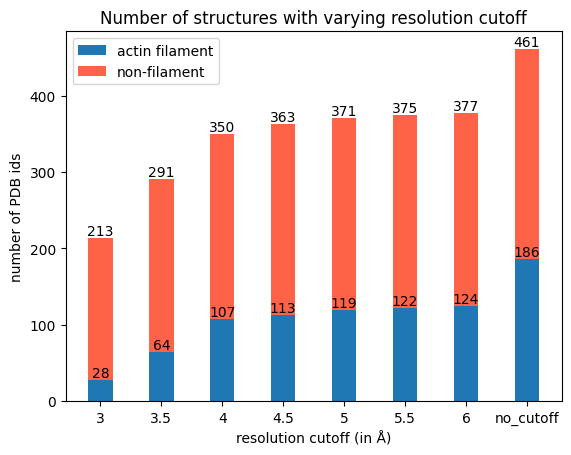

In [ ]:
plot_dict = {}
plot_dict2 = {}
master_lst =[]
master_lst2 = []
res_cutoff = [3,3.5,4,4.5,5,5.5,6]
no_res_list_all = []
no_res_list_f = []

for ress in res_cutoff:
	loop_lst = []
	for index,row in df.iterrows():
		res = row['resolution']
		#res = res[:-1]
		try:
			if float(res) <= ress:
				loop_lst.append(row['entity_id'][0:4])
		except ValueError:
			no_res_list_all.append(row['entity_id'][0:4])
			pass
	loop_lst = list(set(loop_lst))
	master_lst.append(len(loop_lst))
	loop_lst2 = []

	for index,row in df3.iterrows():
		res = row['resolution']#[1:]
		#res = res[:-1]
		try:
			if float(res) <= ress:
				loop_lst2.append(row['entity_id'][0:4])
		except ValueError:
			no_res_list_f.append(row['entity_id'][0:4])
			pass
	loop_lst2 = list(set(loop_lst2))
	master_lst2.append(len(loop_lst2))
#print(master_lst,master_lst2)

no_res_list_all = list(set(no_res_list_all))
no_res_list_f = list(set(no_res_list_f))

for i in range(0,len(res_cutoff)):
  plot_dict[str(res_cutoff[i])] = master_lst[i] - master_lst2[i]

plot_dict['no_cutoff'] = len(all_actin_pdbs) - len(all_actin_filament_pdbs)

for i in range(0,len(res_cutoff)):
  plot_dict2[str(res_cutoff[i])] = master_lst2[i]

plot_dict2['no_cutoff'] = len(all_actin_filament_pdbs)

print("non-filament actin structures: ", plot_dict)
print("filament actin structures: ", plot_dict2)

x = list(plot_dict.keys())
y1 = list(plot_dict.values())
y2 = list(plot_dict2.values())

fig, ax = plt.subplots()

bars2 = ax.bar(x,y2, width = 0.4, label = 'actin filament')
ax.bar_label(bars2)
bars = ax.bar(x,y1,bottom = y2,color = 'tomato',width= 0.4, label = 'non-filament')
ax.bar_label(bars)
ax.legend()
plt.xlabel('resolution cutoff (in Å)')
plt.ylabel('number of PDB ids')
plt.title('Number of structures with varying resolution cutoff')
plt.show()